Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.3789 - loss: 1.6055 - val_accuracy: 0.3684 - val_loss: 1.3631
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.3377 - loss: 1.3705 - val_accuracy: 0.2895 - val_loss: 1.1250
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.4032 - loss: 1.0825 - val_accuracy: 0.2895 - val_loss: 1.0991
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.4557 - loss: 1.0365 - val_accuracy: 0.4474 - val_loss: 1.0682
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.5247 - loss: 0.9841 - val_accuracy: 0.4474 - val_loss: 1.0810
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.5977 - loss: 0.9112 - val_accuracy: 0.4474 - val_loss: 1.1197
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.5100 - loss: 1.0343 - val_accuracy: 0.4474 - val_loss: 1.1224
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.5877 - loss: 0.8773 - val_accuracy: 0.5263 - val_loss:

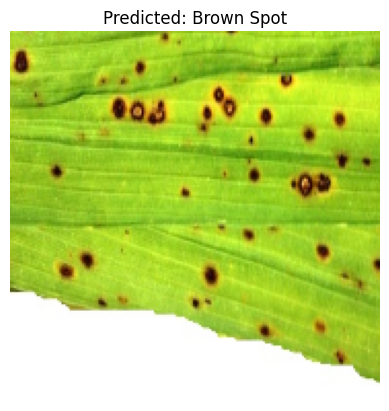

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pathlib
import random
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split

# Path to dataset folder
data_dir = pathlib.Path('./rice_leaf_diseases')

# Label dictionary for the classes
labels_dict = {
    'bacteria': 0,
    'brown': 1,
    'smut': 2,
}

# Create a dictionary containing images of each disease
image_dict = {
    "bacteria": list(data_dir.glob("Bacterial leaf blight/*")),
    "brown": list(data_dir.glob("Brown spot/*")),
    "smut": list(data_dir.glob("Leaf smut/*")),
}

# Prepare dataset X (images) and y (labels)
X, y = [], []

for name, images in image_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        resized_img = cv2.resize(img, (180, 180))
        X.append(resized_img)
        y.append(labels_dict[name])

X = np.array(X)
y = np.array(y)

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=0)

# Normalize the images
X_train_scaled = X_train / 255.0
X_val_scaled = X_val / 255.0
X_test_scaled = X_test / 255.0

# Data Augmentation Pipeline
data_augmentation = Sequential([
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.1),
    layers.RandomFlip("horizontal")
])

# Build the CNN Model (removed LSTM since images are not sequences)
num_classes = 3

model = Sequential([
    data_augmentation,

    # CNN Layers for feature extraction
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Flatten the CNN output
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Added softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Implement Early Stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# Train the model
model.fit(X_train_scaled, y_train, epochs=40, validation_data=(X_val_scaled, y_val), callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# ✅ Save Model as .pkl
with open("rice_leaf_disease_model.pkl", "wb") as f:
    pickle.dump({"model_json": model.to_json(), "weights": model.get_weights()}, f)

print("Model saved as .pkl successfully!")

# ✅ Load Model from .pkl
from tensorflow.keras.models import model_from_json

with open("rice_leaf_disease_model.pkl", "rb") as f:
    data = pickle.load(f)

# Recreate model from JSON
model = model_from_json(data["model_json"])
model.set_weights(data["weights"])

print("Model loaded successfully from .pkl!")

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Random image prediction
all_images = list(data_dir.glob("*/*"))
random_image_path = random.choice(all_images)

# Load and preprocess the random image
new_image = cv2.imread(str(random_image_path))
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
new_image = cv2.resize(new_image, (180, 180))
new_image = new_image / 255.0
new_image = np.expand_dims(new_image, axis=0)  # Add batch dimension

# Predict the class for the new image
labels_dict1 = {0: "Bacterial Leaf Blight", 1: "Brown Spot", 2: "Leaf Smut"}
predicted_value = model.predict(new_image)
predicted_class = np.argmax(predicted_value)
predicted_label = labels_dict1[predicted_class]

print(f"Predicted Class: {predicted_label}")

# Display the image and its predicted label
plt.axis('off')
plt.imshow(new_image[0])
plt.title(f"Predicted: {predicted_label}")
plt.show()


In [12]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import cv2
# import pathlib
# import random
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers, Sequential
# from sklearn.model_selection import train_test_split

# # Path to dataset folder
# data_dir = pathlib.Path('./rice_leaf_diseases')

# # Label dictionary for the classes
# labels_dict = {
#     'bacteria': 0,
#     'brown': 1,
#     'smut': 2,
# }

# # Create a dictionary containing images of each disease
# image_dict = {
#     "bacteria": list(data_dir.glob("Bacterial leaf blight/*")),
#     "brown": list(data_dir.glob("Brown spot/*")),
#     "smut": list(data_dir.glob("Leaf smut/*")),
# }

# # Prepare dataset X (images) and y (labels)
# X, y = [], []

# for name, images in image_dict.items():
#     for image in images:
#         img = cv2.imread(str(image))
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
#         resized_img = cv2.resize(img, (180, 180))
#         X.append(resized_img)
#         y.append(labels_dict[name])

# X = np.array(X)
# y = np.array(y)

# # Split dataset into training, validation, and test sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=0)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=0)

# # Normalize the images
# X_train_scaled = X_train / 255.0
# X_val_scaled = X_val / 255.0
# X_test_scaled = X_test / 255.0

# # Data Augmentation Pipeline
# data_augmentation = Sequential([
#     layers.RandomZoom(0.2),
#     layers.RandomRotation(0.1),
#     layers.RandomFlip("horizontal")
# ])

# # Build the CNN Model (removed LSTM since images are not sequences)
# num_classes = 3

# model = Sequential([
#     data_augmentation,

#     # CNN Layers for feature extraction
#     layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(180, 180, 3)),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),

#     # Flatten the CNN output
#     layers.Flatten(),

#     # Fully connected layers
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_classes, activation='softmax')  # Added softmax activation
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy'])

# # Implement Early Stopping to prevent overfitting
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=5, restore_best_weights=True
# )

# # Train the model
# model.fit(X_train_scaled, y_train, epochs=40, validation_data=(X_val_scaled, y_val), callbacks=[early_stopping])

# # Evaluate the model on the test set
# test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
# print(f"Test Accuracy: {test_acc:.2f}")

# # Make predictions on the test set
# predictions = model.predict(X_test_scaled)

# # Random image prediction
# all_images = list(data_dir.glob("*/*"))
# random_image_path = random.choice(all_images)

# # Load and preprocess the random image
# new_image = cv2.imread(str(random_image_path))
# new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
# new_image = cv2.resize(new_image, (180, 180))
# new_image = new_image / 255.0
# new_image = np.expand_dims(new_image, axis=0)  # Add batch dimension

# # Predict the class for the new image
# labels_dict1 = {0: "Bacterial Leaf Blight", 1: "Brown Spot", 2: "Leaf Smut"}
# predicted_value = model.predict(new_image)
# predicted_class = np.argmax(predicted_value)
# predicted_label = labels_dict1[predicted_class]

# print(f"Predicted Class: {predicted_label}")

# # Display the image and its predicted label
# plt.axis('off')
# plt.imshow(new_image[0])
# plt.title(f"Predicted: {predicted_label}")
# plt.show()


In [13]:
model.save("rice_leaf_disease_model.h5")